# Feature Importance

Beeswarm Plot based on SHAP value for G-Global+ model.

In [1]:
%load_ext jupyter_black

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

/Users/mersedehkooshki/opt/anaconda3/envs/global-storm/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Read csv file and import to df
df = pd.read_csv("/Users/mersedehkooshki/03_new_model_training/data/updated_corr.csv")
df

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,strong_roof_strong_wall,...,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged,percent_houses_damaged_5years
0,DURIAN,2006,101,0.0,303.180555,0.122917,0.085417,31.000000,-0.213039,22.580645,...,2.699781,5.762712,3445.709753,1,0.00,0.000000,1.000000,0.000000,0.0,0.000000
1,DURIAN,2006,4475,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,2.639401,...,4.585088,12.799127,8602.645832,1,0.00,0.000000,1.000000,0.000000,0.0,0.000000
2,DURIAN,2006,4639,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,2.639401,...,1.527495,8.833333,5084.012925,1,0.00,0.010000,0.990000,197.339034,0.0,0.000000
3,DURIAN,2006,4640,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,2.639401,...,11.677657,17.530431,55607.865950,1,0.00,0.310000,0.690000,4970.477311,0.0,0.000000
4,DURIAN,2006,4641,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,2.639401,...,17.074011,31.931338,35529.342507,1,0.00,0.770000,0.230000,12408.594656,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141253,MOLAVE,2020,20677,0.0,644.575831,2.543750,0.778646,4449.357133,0.508167,44.762048,...,18.012771,36.304688,21559.003490,1,0.08,0.080000,0.840000,17619.701390,0.0,0.000000
141254,MOLAVE,2020,20678,0.0,655.685233,2.558333,0.861458,1521.435795,-0.174100,44.762048,...,13.163042,65.687266,12591.742022,1,0.00,0.420000,0.580000,5623.069564,0.0,0.000000
141255,MOLAVE,2020,20679,0.0,666.794635,2.975000,0.949479,930.647069,-0.244286,25.078318,...,10.901755,37.414996,19740.596834,1,0.00,0.109091,0.890909,5912.671746,0.0,0.015207
141256,MOLAVE,2020,20680,0.0,677.904037,2.889583,1.083333,1800.666044,0.038000,16.796996,...,17.917650,105.812452,26363.303778,1,0.03,0.250000,0.720000,11254.164413,0.0,0.020806


In [7]:
# Remove zeros from wind_speed
df = df[(df[["wind_speed"]] != 0).any(axis=1)]
df = df.drop(columns=["grid_point_id", "typhoon_year"])

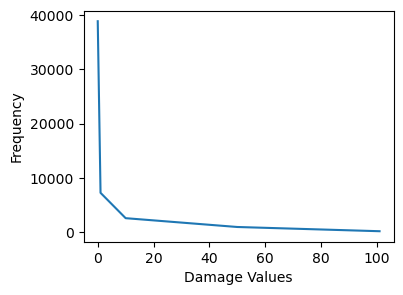

In [8]:
# Hist plot after removing rows where windspeed is 0
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_houses_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [9]:
print(samples_per_bin2)
print(binsP2)

[38901  7232  2552   925   144]
[0.00e+00 9.00e-05 1.00e+00 1.00e+01 5.00e+01 1.01e+02]


In [10]:
# Check the bins' intervalls
df["percent_houses_damaged"].value_counts(bins=binsP2)

(-0.001, 9e-05]    38901
(9e-05, 1.0]        7232
(1.0, 10.0]         2552
(10.0, 50.0]         925
(50.0, 101.0]        144
Name: percent_houses_damaged, dtype: int64

In [11]:
bin_index2 = np.digitize(df["percent_houses_damaged"], bins=binsP2)

In [12]:
y_input_strat = bin_index2

In [14]:
features = [
    "wind_speed",
    "track_distance",
    "total_houses",
    "rainfall_max_6h",
    "rainfall_max_24h",
    "rwi",
    "mean_slope",
    "std_slope",
    "mean_tri",
    "std_tri",
    "mean_elev",
    "coast_length",
    "with_coast",
    "urban",
    "rural",
    "water",
    "total_pop",
    "percent_houses_damaged_5years",
]

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["percent_houses_damaged"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Index(['wind_speed', 'track_distance', 'total_houses', 'rainfall_max_6h',
       'rainfall_max_24h', 'rwi', 'mean_slope', 'std_slope', 'mean_tri',
       'std_tri', 'mean_elev', 'coast_length', 'with_coast', 'urban', 'rural',
       'water', 'total_pop', 'percent_houses_damaged_5years'],
      dtype='object')

In [15]:
# Split dataset into training set and test set

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df["percent_houses_damaged"], stratify=y_input_strat, test_size=0.2
)

In [16]:
# XGBoost Reduced Overfitting
xgb = XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    colsample_bylevel=0.8,
    colsample_bynode=0.8,
    colsample_bytree=0.8,
    gamma=3,
    eta=0.01,
    importance_type="gain",
    learning_rate=0.1,
    max_delta_step=0,
    max_depth=4,
    min_child_weight=1,
    missing=1,
    n_estimators=100,
    early_stopping_rounds=10,
    n_jobs=1,
    nthread=None,
    objective="reg:squarederror",
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    seed=None,
    silent=None,
    subsample=0.8,
    verbosity=1,
    eval_metric=["rmse", "logloss"],
    random_state=0,
)

eval_set = [(X_train, y_train)]
xgb_model = xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

[17:09:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [17]:
X_train4shapely = pd.DataFrame(data=X_train, columns=features)

In [18]:
explainer_xgb = shap.Explainer(xgb_model, X_train4shapely)
shap_values_xgb = explainer_xgb(X_train4shapely)

 98%|===================| 38831/39803 [00:33<00:00]        

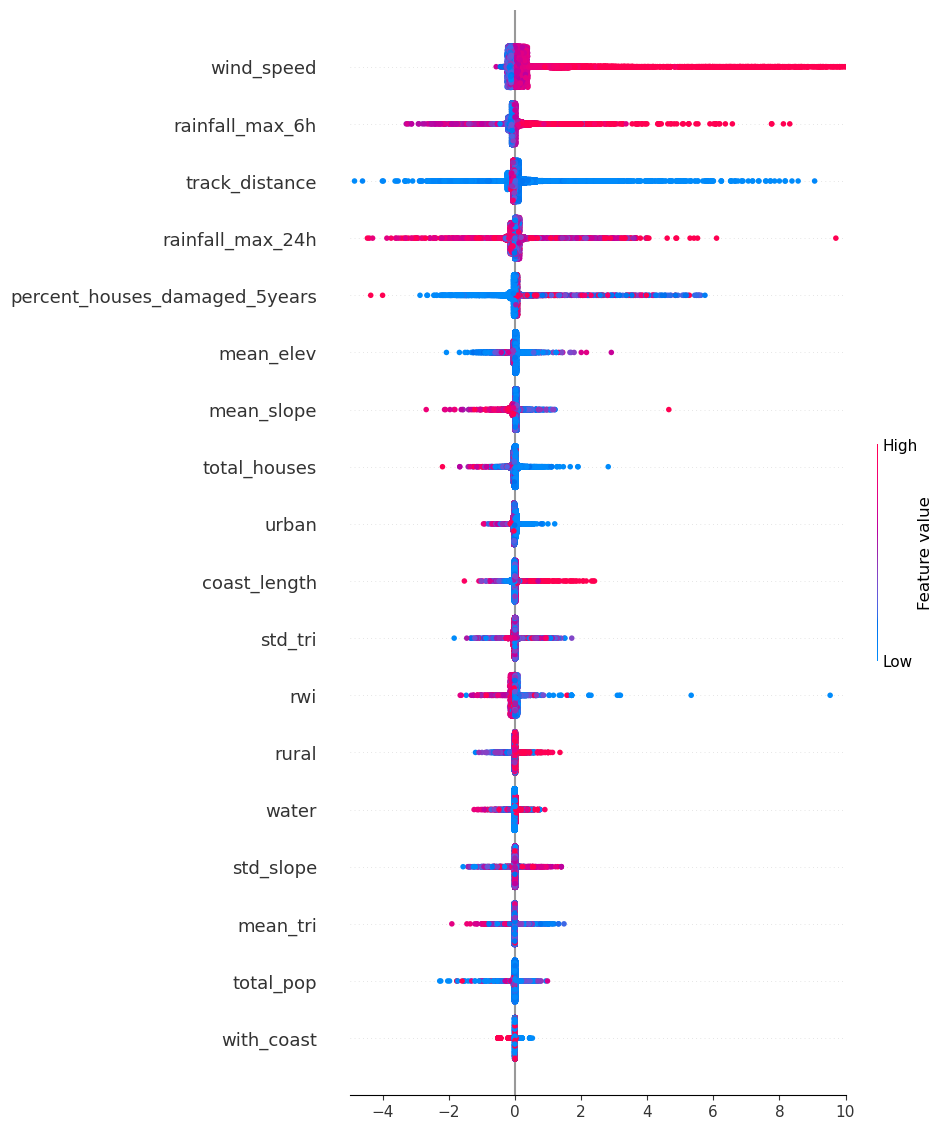

In [26]:
shap.summary_plot(shap_values_xgb, max_display=30, plot_size=0.7, show=False)
ax = plt.gca()

ax.set_xlabel("")
# You can change the min and max value of xaxis by changing the arguments of:
ax.set_xlim(-5, 10)
# plt.show()

plt.savefig("SHAP_updated1.pdf", bbox_inches="tight")

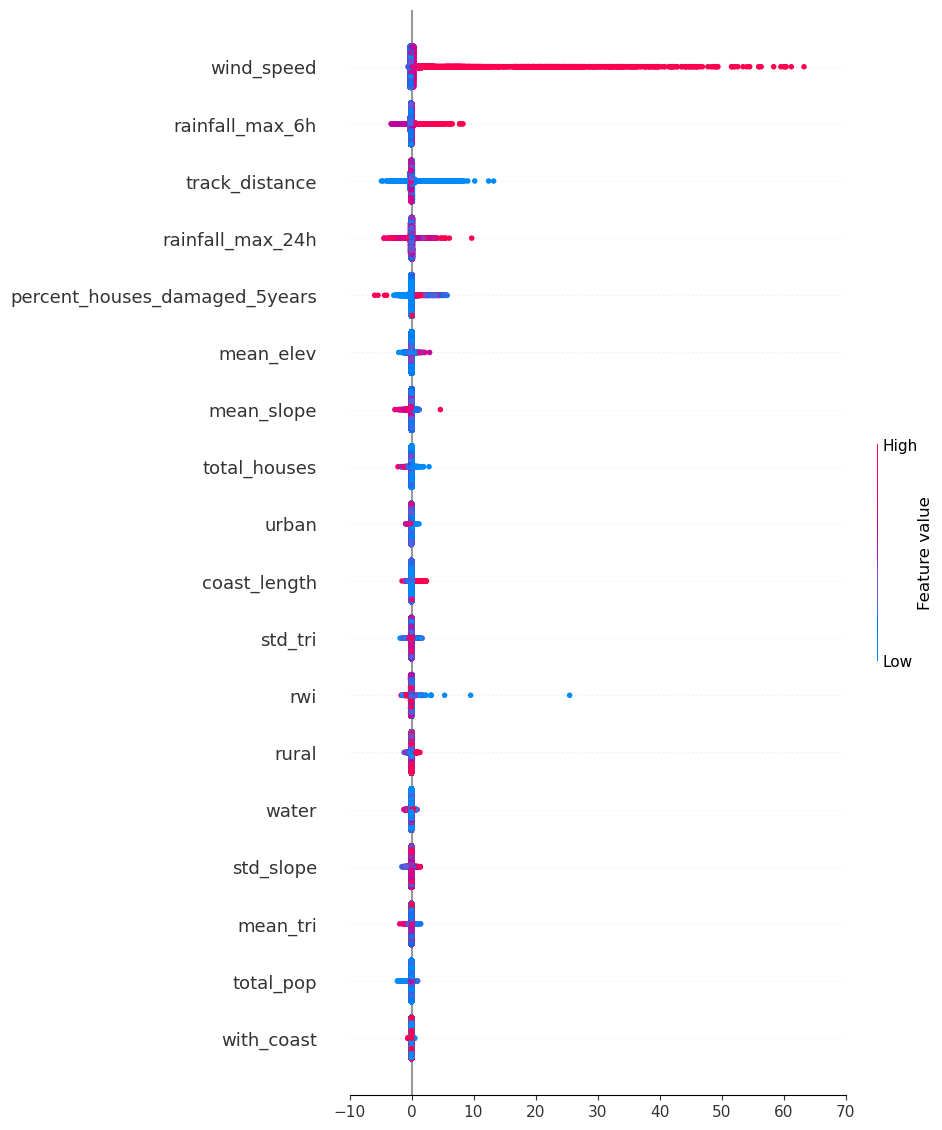

In [27]:
# Calculate shap_values
shap.summary_plot(shap_values_xgb, max_display=30, plot_size=0.7, show=False)
ax = plt.gca()

ax.set_xlabel("")
# You can change the min and max value of xaxis by changing the arguments of:
ax.set_xlim(-10, 70)
# plt.show()


plt.savefig("SHAP_updated2.pdf", bbox_inches="tight")